<a href="https://colab.research.google.com/github/danielececcarelli/DL_cardiac_segmentation/blob/main/acdc_data/acdc_train_with_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U segmentation-models

     |████████████████████████████████| 51kB 6.2MB/s 


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls "/content/drive/My Drive/"

 09022019-DSC_0016.jpg    RLbook2018.pdf
 09022019-DSC_0025.jpg    x_2d_test.npy
 09022019-DSC_0037.jpg    x_2d_train.npy
 09022019-DSC_0040.jpg    x_2d_val.npy
'Colab Notebooks'/        y_2d_test.npy
 foo.txt                  y_2d_train.npy
'PACS+Tesi Manzoni.zip'   y_2d_val.npy
 PACS.zip                'Zerocalcare - Kobane Calling.pdf'
 risultati50epochs/


In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import segmentation_models as sm
import numpy as np

path = "/content/drive/My Drive/"

x_train = np.load(path+"x_2d_train.npy")
y_train = np.load(path+"y_2d_train.npy")

x_val = np.load(path+"x_2d_val.npy")
y_val = np.load(path+"y_2d_val.npy")

x_test = np.load(path+"x_2d_test.npy")
y_test = np.load(path+"y_2d_test.npy")

Segmentation Models: using `tf.keras` framework.


In [ ]:
### standardization of train
for i in range(x_train.shape[0]):
    x_train[i,:,:,0] = x_train[i,:,:,0]/(np.max(x_train[i,:,:,0]))
    
### standardization of val
for i in range(x_val.shape[0]):
    x_val[i,:,:,0] = x_val[i,:,:,0]/(np.max(x_val[i,:,:,0]))
    
### standardization of test
for i in range(x_test.shape[0]):
    x_test[i,:,:,0] = x_test[i,:,:,0]/(np.max(x_test[i,:,:,0]))

In [ ]:
dim1,dim2,dim3,_ = y_train.shape
y_train_new = np.zeros(shape = (dim1,dim2,dim3,4))


for i in range(y_train.shape[0]):
    y_train_new[i,:,:,0] = (y_train[i,:,:,0]==1)
    y_train_new[i,:,:,1] = (y_train[i,:,:,0]==2)
    y_train_new[i,:,:,2] = (y_train[i,:,:,0]==3)
    y_train_new[i,:,:,3] = (y_train[i,:,:,0]==0)


dim1,dim2,dim3,_ = y_val.shape
y_val_new = np.zeros(shape = (dim1,dim2,dim3,4))


for i in range(y_val.shape[0]):
    y_val_new[i,:,:,0] = (y_val[i,:,:,0]==1)
    y_val_new[i,:,:,1] = (y_val[i,:,:,0]==2)
    y_val_new[i,:,:,2] = (y_val[i,:,:,0]==3)
    y_val_new[i,:,:,3] = (y_val[i,:,:,0]==0)



dim1,dim2,dim3,_ = y_test.shape
y_test_new = np.zeros(shape = (dim1,dim2,dim3,4))

for i in range(y_test.shape[0]):
    y_test_new[i,:,:,0] = (y_test[i,:,:,0]==1)
    y_test_new[i,:,:,1] = (y_test[i,:,:,0]==2)
    y_test_new[i,:,:,2] = (y_test[i,:,:,0]==3)
    y_test_new[i,:,:,3] = (y_test[i,:,:,0]==0)


y_train = y_train_new
y_val = y_val_new
y_test = y_test_new

In [ ]:
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

from keras.layers import Input, Conv2D
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
bb = "vgg16"
input_shape = (256,256,3)
c = 4 ### giusto!
enc_weights = "imagenet"
activation = "softmax"
base_model = sm.Unet(backbone_name = bb, input_shape = input_shape, classes = c, activation=activation, encoder_weights = enc_weights)

# define number of channels
N = x_train.shape[-1] # = 1,
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

modelUnet = Model(inp, out, name=base_model.name)

lr = 0.0001
optim = Adam(lr)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 1, 1, 0.5])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

modelUnet.compile(optim, total_loss, metrics)

In [ ]:
path = "/content/drive/My Drive/"

ep = 100 #100

# fit model
history = modelUnet.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=ep,
    validation_data=(x_val, y_val))

name = path + "risultati50epochs/modelUnet_" + str(ep) + "epochs.keras"
modelUnet.save(name)

Epoch 1/100
150/150 [==============================] - 23s 156ms/step - loss: 0.9134 - iou_score: 0.2549 - f1-score: 0.3516 - val_loss: 0.8627 - val_iou_score: 0.3754 - val_f1-score: 0.5221
Epoch 2/100
150/150 [==============================] - 22s 149ms/step - loss: 0.7012 - iou_score: 0.5512 - f1-score: 0.6684 - val_loss: 0.7557 - val_iou_score: 0.5313 - val_f1-score: 0.6510
Epoch 3/100
150/150 [==============================] - 22s 150ms/step - loss: 0.5086 - iou_score: 0.6659 - f1-score: 0.7751 - val_loss: 0.5738 - val_iou_score: 0.6255 - val_f1-score: 0.7429
Epoch 4/100
150/150 [==============================] - 22s 150ms/step - loss: 0.3744 - iou_score: 0.7163 - f1-score: 0.8201 - val_loss: 0.4435 - val_iou_score: 0.6305 - val_f1-score: 0.7477
Epoch 5/100
150/150 [==============================] - 22s 150ms/step - loss: 0.3237 - iou_score: 0.7298 - f1-score: 0.8307 - val_loss: 0.3875 - val_iou_score: 0.6501 - val_f1-score: 0.7628
Epoch 6/100
150/150 [=============================

In [ ]:
history.history['f1-score']

[0.351620614528656,
 0.6683703660964966,
 0.7751338481903076,
 0.8201014995574951,
 0.8306825757026672,
 0.8409537076950073,
 0.8449708819389343,
 0.8517090082168579,
 0.8629547357559204,
 0.8698727488517761,
 0.8765891790390015,
 0.884583055973053,
 0.8903172612190247,
 0.8998470306396484,
 0.8970333933830261,
 0.9086145758628845,
 0.9143220782279968,
 0.9200183153152466,
 0.9260104298591614,
 0.9241331815719604,
 0.9275463819503784,
 0.933941662311554,
 0.9351240992546082,
 0.940933108329773,
 0.9421818852424622,
 0.9453621506690979,
 0.9482905268669128,
 0.9506411552429199,
 0.9508054852485657,
 0.9512884616851807,
 0.9520646929740906,
 0.9528566598892212,
 0.9557129144668579,
 0.9583715796470642,
 0.9593533277511597,
 0.9585555195808411,
 0.9597544074058533,
 0.9596447944641113,
 0.9617597460746765,
 0.9621615409851074,
 0.9625267386436462,
 0.9631776213645935,
 0.9641878008842468,
 0.965021550655365,
 0.9651390314102173,
 0.9659726023674011,
 0.9667866230010986,
 0.967954516410827

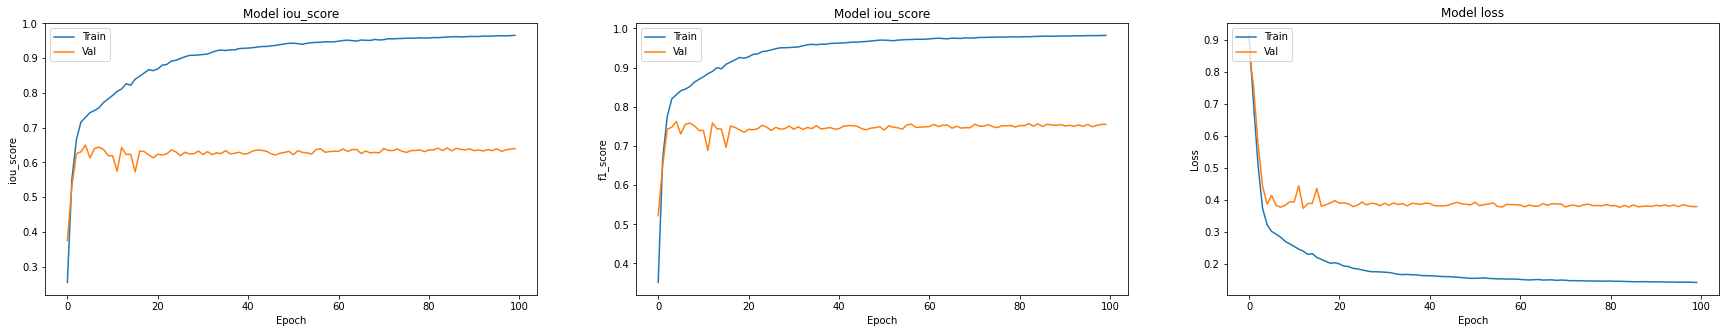

In [ ]:
### sistemare!!!

# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation iou_score values
plt.subplot(132)
plt.plot(history.history["f1-score"])
plt.plot(history.history['val_f1-score'])
plt.title('Model iou_score')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(133)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
#plt.show()
name = path + "risultati50epochs/loss_" + str(ep) + "epochs.png"
plt.savefig(name)

name =  str(ep) + "epochs.csv"
np.savetxt(path + "risultati50epochs/loss_" + name, history.history['loss'])
np.savetxt(path + "risultati50epochs/val_loss_" + name, history.history['val_loss'])
np.savetxt(path + "risultati50epochs/f1_" + name, history.history['f1-score'])
np.savetxt(path + "risultati50epochs/val_f1_" + name, history.history['val_f1-score'])
np.savetxt(path + "risultati50epochs/iou_" + name, history.history['iou_score'])
np.savetxt(path + "risultati50epochs/val_iou_" + name, history.history['val_iou_score'])


In [ ]:
n = 0

x_prova = x_train[n:(n+1),:,:,:]
y_prova = y_train[n:(n+1),:,:,:]

y_pred = modelUnet.predict(x_prova)

In [ ]:
y_prova[0,100:150,100,0]

array([2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
y_pred[0,100:150,100,2]>0.1

1.0

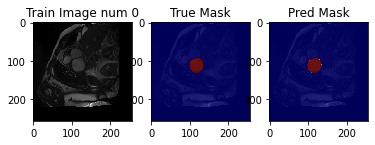

In [ ]:
n = 0


x_prova = x_train[n:(n+1),:,:,:]
y_prova = y_train[n:(n+1),:,:,:]

y_pred = modelUnet.predict(x_prova)

plt.figure()
plt.subplot(1,3,1)
tit = "Train Image num " + str(n)
plt.title(tit)
plt.imshow(x_prova[n,:,:,0], 'gray', interpolation='none')
plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(x_prova[n,:,:,0], 'gray', interpolation='none')
plt.imshow(y_prova[n,:,:,2], 'jet', interpolation='none', alpha=0.7)
plt.subplot(1,3,3)
plt.title("Pred Mask")
plt.imshow(x_prova[n,:,:,0], 'gray', interpolation='none')
plt.imshow(y_pred[0,:,:,2], 'jet', interpolation='none', alpha=0.7)

np.max(y_pred)

(200, 256, 256, 1)
(56, 256, 256, 1)


(200, 256, 256, 3)


Epoch 1/10
25/25 [==============================] - 227s 9s/step - loss: 0.9545 - iou_score: 0.0233 - val_loss: 1.0000 - val_iou_score: 1.2126e-09
Epoch 2/10
25/25 [==============================] - 229s 9s/step - loss: 0.9134 - iou_score: 0.0454 - val_loss: 1.0000 - val_iou_score: 1.2126e-09
Epoch 3/10
25/25 [==============================] - 228s 9s/step - loss: 0.8754 - iou_score: 0.0666 - val_loss: 1.0000 - val_iou_score: 1.5529e-09
Epoch 4/10
25/25 [==============================] - 227s 9s/step - loss: 0.8371 - iou_score: 0.0894 - val_loss: 1.0000 - val_iou_score: 1.2111e-09
Epoch 5/10
25/25 [==============================] - 227s 9s/step - loss: 0.8525 - iou_score: 0.0805 - val_loss: 1.0000 - val_iou_score: 1.1262e-09
Epoch 6/10
25/25 [==============================] - 231s 9s/step - loss: 0.8620 - iou_score: 0.0806 - val_loss: 1.0000 - val_iou_score: 1.1065e-09
Epoch 7/10
25/25 [==============================] - 229s 9s/step - loss: 0.9330 - iou_score: 0.0354 - val_loss: 1.0000

ValueError: in user code:

    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/daniele/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer block1_conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [32, 256, 3]


(1, 256, 256, 1)


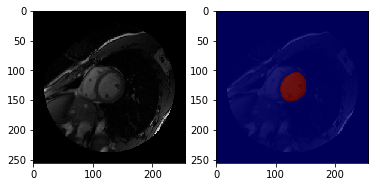

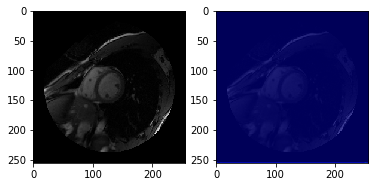